<a href="https://colab.research.google.com/github/turtlemana/Long-Short-Strategy/blob/main/Long_Short_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Long Short Strategy, using MLP and RandomForestClassifier



*   Applying Random Search CV, or Grid CV to find optimal hyperparameter
*   Using crsp_m_2000.csv CRSP file 


*   Training data: before 2010
*   Testing data: after 2010





In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
crsp=pd.read_csv("/content/gdrive/My Drive/crsp_m_2000.csv")

crsp.head()

Mounted at /content/gdrive


,date,permno,prc,ret,shrout,vol
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0


## Preprocessing



*   Generating variable that which trading volumne relative to shares outstanding




*   Inspecting the data's description
*   Dropping the missing value



*   Winsorizing 1%



In [ ]:
crsp['relvol'] = 0.1*crsp.vol/crsp.shrout # trading vol relative to shares outstanding
crsp['date'] = pd.to_datetime(crsp.date) # string to Timestamp
crsp['prc'] = crsp.prc.abs() # abs(prc)

In [ ]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609247 entries, 0 to 609246
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    609247 non-null  datetime64[ns]
 1   permno  609247 non-null  int64         
 2   prc     593733 non-null  float64       
 3   ret     595044 non-null  float64       
 4   shrout  609247 non-null  float64       
 5   vol     598363 non-null  float64       
 6   relvol  598363 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 32.5 MB


In [ ]:
crsp.describe()

,permno,prc,ret,shrout,vol,relvol
count,609247.000000,593733.000000,595044.000000,6.092470e+05,5.983630e+05,598363.000000
mean,87076.846204,20.088695,0.006790,6.777919e+04,1.328973e+05,0.168159
std,3584.821611,55.504162,0.208501,1.761328e+05,4.585374e+05,0.747183
min,80000.000000,0.007800,-1.000000,2.000000e+00,0.000000e+00,0.000000
25%,84229.000000,3.950000,-0.077211,1.177700e+04,4.859000e+03,0.032650
50%,87236.000000,11.030000,0.000000,2.705700e+04,2.703100e+04,0.090839
75%,90081.000000,24.062500,0.073465,5.769050e+04,9.896500e+04,0.196360
max,93436.000000,4736.000000,15.774193,6.433649e+06,3.875707e+07,262.246178


In [ ]:
crsp=crsp.dropna()
len(crsp)

590656

In [ ]:
lb = crsp.quantile(q = 0.01)
ub = crsp.quantile(q = 0.99)

crsp = crsp[crsp.ret >= lb.ret]
crsp = crsp[crsp.ret <= ub.ret]

In [ ]:
len(crsp)

578864

## Generating Target Label



*  Dividing 10 bundles of stocks for each date,
*  Sorted by previous return






In [ ]:
crsp['label2'] = pd.concat([pd.qcut(-g, 10, labels=False) for k, g in crsp.groupby('date')['ret']])

y = [i**2 for i in range(10)]


In [ ]:
crsp.sort_values(['permno','date'], inplace=True)
crsp['label'] = crsp.groupby('date')['ret'].apply(lambda x: pd.qcut(-x, 10, labels=False)) 
crsp['tgt_ret'] = crsp.groupby('permno')['ret'].shift(-1) 
crsp['tgt_label'] = crsp.groupby('permno')['label'].shift(-1) 
crsp.dropna(inplace=True) 

In [ ]:
crsp.head()

,date,permno,prc,ret,shrout,vol,relvol,label2,label,tgt_ret,tgt_label
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0,0.043800,4,4,-0.022388,6.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0,0.067418,6,6,-0.099237,6.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0,0.068297,6,6,-0.033898,3.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0,0.059640,3,3,0.078947,1.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0,0.051468,1,1,0.097561,3.0


## Creating momentum variables


*   Considering size by using prc and shrout features
*   generating 3, 6, 12 months momentum variable using cumulative return



In [ ]:
# Create features
# add size
import numpy as np
crsp['size'] = np.log(crsp.prc * crsp.shrout)

# add momentum factors
# cumulative return
crsp['cumret'] = crsp.groupby('permno')['ret'].apply(lambda x: (1+x).cumprod())
gb = crsp.groupby('permno')
numer = gb.shift(1)

# 3-month momentum
denom = gb.shift(3)
crsp['mom3m'] = numer.cumret/denom.cumret - 1
crsp['prd3m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 6-month momentum
denom = gb.shift(6)
crsp['mom6m'] = numer.cumret/denom.cumret - 1
crsp['prd6m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 12-month momentum
denom = gb.shift(12)
crsp['mom12m'] = numer.cumret/denom.cumret - 1
crsp['prd12m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

crsp

,date,permno,prc,ret,shrout,vol,relvol,label2,label,tgt_ret,tgt_label,size,cumret,mom3m,prd3m,mom6m,prd6m,mom12m,prd12m
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,4,4,-0.022388,6.0,10.988018,0.992593,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,6,6,-0.099237,6.0,10.970740,0.970370,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,6,6,-0.033898,3.0,10.868197,0.874074,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,3,3,0.078947,1.0,10.833711,0.844444,-0.119403,3.0,NaN,NaN,NaN,NaN
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,1,1,0.097561,3.0,10.915023,0.911111,-0.129771,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93436,298.140015,-0.130660,170593.0,1723953.0,1.010565,9,9,0.011806,5.0,17.744599,6.909528,0.166894,3.0,-0.032062,6.0,0.060222,12.0
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,5,5,-0.122290,8.0,17.756336,6.991105,0.047097,3.0,-0.130939,6.0,-0.162293,12.0
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,8,8,0.274011,0.0,17.631655,6.136163,-0.120397,3.0,0.133506,6.0,-0.115626,12.0
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,0,0,0.039013,3.0,17.874728,7.817542,-0.111927,3.0,-0.099115,6.0,-0.201369,12.0


In [ ]:
# remove rows with missing months
crsp = crsp[crsp.prd3m==3]
crsp = crsp[crsp.prd6m==6]
crsp = crsp[crsp.prd12m==12]

crsp.drop(columns=['prd3m','prd6m','prd12m'], inplace=True)
crsp

,date,permno,prc,ret,shrout,vol,relvol,label2,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m
12,2001-01-31,80000,20.125000,0.025478,3564.0,1869.0,0.052441,6,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642
13,2001-02-28,80000,20.062500,-0.003106,3473.0,811.0,0.023352,3,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008
14,2001-03-30,80000,22.062500,0.099688,3466.0,2518.0,0.072649,1,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169
15,2001-04-30,80000,21.445000,-0.027989,3466.0,1936.0,0.055857,6,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246
16,2001-05-31,80000,21.660000,0.010026,3483.0,905.0,0.025983,5,5,-0.021237,5.0,11.231117,1.283556,0.068910,0.151409,0.394797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93436,298.140015,-0.130660,170593.0,1723953.0,1.010565,9,9,0.011806,5.0,17.744599,6.909528,0.166894,-0.032062,0.060222
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,5,5,-0.122290,8.0,17.756336,6.991105,0.047097,-0.130939,-0.162293
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,8,8,0.274011,0.0,17.631655,6.136163,-0.120397,0.133506,-0.115626
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,0,0,0.039013,3.0,17.874728,7.817542,-0.111927,-0.099115,-0.201369


In [ ]:
import matplotlib.pyplot as plt
crsp[['tgt_ret', 'size', 'mom3m', 'mom6m', 'mom12m']].corr() # correlations of all pairs


,tgt_ret,size,mom3m,mom6m,mom12m
tgt_ret,1.000000,0.013780,0.032066,0.028684,0.035437
size,0.013780,1.000000,0.108584,0.161473,0.208675
mom3m,0.032066,0.108584,1.000000,0.623639,0.391253
mom6m,0.028684,0.161473,0.623639,1.000000,0.637747
mom12m,0.035437,0.208675,0.391253,0.637747,1.000000


In [ ]:
crsp.corr().tgt_ret.sort_values(ascending=False) # correlations between the target and the features.

tgt_ret      1.000000
mom12m       0.035437
mom3m        0.032066
mom6m        0.028684
size         0.013780
ret          0.012303
label2       0.010366
label        0.010366
prc          0.004117
cumret       0.003351
shrout      -0.001750
vol         -0.007684
permno      -0.014803
relvol      -0.020155
tgt_label   -0.826067
Name: tgt_ret, dtype: float64

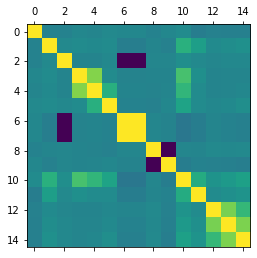

In [ ]:
plt.matshow(crsp.corr())

In [ ]:
# Save the filtered file
crsp.to_csv('crsp_filtered.csv', index=False)

In [ ]:
from google.colab import files 
files.download("crsp_filtered.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
crsp=pd.read_csv("/content/gdrive/My Drive/crsp_filtered.csv")

Mounted at /content/gdrive


In [ ]:
crsp.head()

,date,permno,prc,ret,shrout,vol,relvol,label2,label,tgt_ret,tgt_label,size,cumret,mom3m,mom6m,mom12m
0,2001-01-31,80000,20.1250,0.025478,3564.0,1869.0,0.052441,6,6,-0.003106,3.0,11.180602,1.192593,0.019481,0.226563,0.171642
1,2001-02-28,80000,20.0625,-0.003106,3473.0,811.0,0.023352,3,3,0.099688,1.0,11.151626,1.188889,0.080537,0.183824,0.229008
2,2001-03-30,80000,22.0625,0.099688,3466.0,2518.0,0.072649,1,1,-0.027989,6.0,11.244636,1.307407,0.022293,0.163043,0.360169
3,2001-04-30,80000,21.4450,-0.027989,3466.0,1936.0,0.055857,6,6,0.010026,5.0,11.216248,1.270815,0.096273,0.146104,0.548246
4,2001-05-31,80000,21.6600,0.010026,3483.0,905.0,0.025983,5,5,-0.021237,5.0,11.231117,1.283556,0.068910,0.151409,0.394797


##Train, Test Split



*   Splitting data into two bundles: before, and after 2010
*   Train set: before 2010


*   Test set: after 2010


*   Independent variables: return, momentum 3/6/12
*   Dependent variable: target label (10th rank)







In [ ]:
before_2010=crsp[crsp.date < '2010-01-01']
after_2010=crsp[crsp.date >= '2010-01-01']

from sklearn.model_selection import train_test_split 
x_train=before_2010[["ret",'mom3m','mom6m','mom12m']].values
x_test=after_2010[["ret",'mom3m','mom6m','mom12m']].values
y_train=before_2010['tgt_label'].values
y_test=after_2010['tgt_label'].values

##Classifier 



*   Random Forest Classifier

      *   According to the Jounral of Risk and Financial Management article: A Random Forests Approach to Predicting Clean Energy
Stock Prices, Decsion tree bagging and random forests predictions of stock price direction are more accurate than those obtained from logit models.
      *  Tree bagging and random forests methods produce accuracy rates of between
85% and 90% while logit models produce accuracy rates of between 55% and 60%. Tree bagging and
random forests are easy to understand and estimate and are useful methods for forecasting the stock
price direction of clean energy stocks. 
    * So it maybe a presumable approach, using Random Forest Classifier for our prediction




    

---




*   Multi Layer Perceptron

    * Neural network will be our baseline model, serving as a comparison for Random Forest Classifier 






In [ ]:
from sklearn import metrics

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(max_depth=None,max_features='auto',min_samples_leaf=1,min_samples_split=6,n_estimators=100)
forest_clf.fit(x_train,y_train)
forest_clf.score(x_test,y_test)


0.11892887362500622

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(40,40), 
                    activation='relu',
                    alpha=0,
                    max_iter=100,
                    verbose=True,
                    early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=5
                   )
clf = clf.fit(x_train, y_train)

Iteration 1, loss = 2.27524995
Validation score: 0.132466
Iteration 2, loss = 2.26231920
Validation score: 0.132383
Iteration 3, loss = 2.25995752
Validation score: 0.131476
Iteration 4, loss = 2.25865699
Validation score: 0.130884
Iteration 5, loss = 2.25822674
Validation score: 0.132741
Iteration 6, loss = 2.25767026
Validation score: 0.132480
Iteration 7, loss = 2.25730815
Validation score: 0.133044
Iteration 8, loss = 2.25715448
Validation score: 0.133731
Iteration 9, loss = 2.25700297
Validation score: 0.132383
Iteration 10, loss = 2.25666478
Validation score: 0.130788
Iteration 11, loss = 2.25662677
Validation score: 0.133938
Iteration 12, loss = 2.25634635
Validation score: 0.133745
Iteration 13, loss = 2.25622541
Validation score: 0.134171
Iteration 14, loss = 2.25599369
Validation score: 0.133717
Iteration 15, loss = 2.25596639
Validation score: 0.132232
Iteration 16, loss = 2.25577438
Validation score: 0.134185
Iteration 17, loss = 2.25586318
Validation score: 0.133621
Iterat

## Random Search CV


*   To find optimal hyper parameter
*   Applying Randomized Search CV both Random Forest Classifier and MLP



In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
np.random.seed(42)

grid={"n_estimators":[100,200,500],"max_depth":[None,5,10,20,30],"max_features":["auto","sqrt"],"min_samples_split":[2,4,6],"min_samples_leaf":[4,6,8]}
forest_clf=RandomForestClassifier(n_jobs=1)
rs_forest_clf=RandomizedSearchCV(estimator=forest_clf,param_distributions=grid,n_iter=10,cv=5,verbose=2)
rs_forest_clf.fit(x_train,y_train)
rs_forest_clf.score(x_test,y_test)

import pickle

fpath = 'rs_forest_clf.pickle' # file name

# Save
pickle.dump(rs_forest_clf, open(fpath, 'wb'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  43.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  43.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  42.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  42.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=  42.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimato

In [ ]:
# in-sample (train set) accuracy
print(clf.score(x_train, y_train)) 

# out-of-sample (test set) accuracy
print(clf.score(x_test, y_test))

0.13636776221871982
0.13547359514210344


In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
grid={"hidden_layer_sizes":[(24,24),(32,32)],"activation":["relu","tanh"],"solver":['sgd','adam'],"alpha":[0,0.05],"learning_rate":['constant','adaptive'],"validation_fraction":[0.3],"max_iter":[100],"verbose":[True]}
mlp_rs=MLPClassifier(max_iter=1)
rs_clf=RandomizedSearchCV(estimator=mlp_rs,param_distributions=grid,n_iter=10,cv=5,verbose=2)
rs_clf.fit(x_train,y_train)
rs_clf.score(x_test,y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Iteration 1, loss = 2.28447618
Iteration 2, loss = 2.26931668
Iteration 3, loss = 2.26721870
Iteration 4, loss = 2.26623653
Iteration 5, loss = 2.26561806
Iteration 6, loss = 2.26518820
Iteration 7, loss = 2.26486339
Iteration 8, loss = 2.26457818
Iteration 9, loss = 2.26439776
Iteration 10, loss = 2.26431158
Iteration 11, loss = 2.26423095
Iteration 12, loss = 2.26406438
Iteration 13, loss = 2.26394213
Iteration 14, loss = 2.26385011
Iteration 15, loss = 2.26379789
Iteration 16, loss = 2.26375493
Iteration 17, loss = 2.26371208
Iteration 18, loss = 2.26368366


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END activation=relu, alpha=0.05, hidden_layer_sizes=(24, 24), learning_rate=constant, max_iter=100, solver=adam, validation_fraction=0.3, verbose=True; total time=  27.6s
Iteration 1, loss = 2.28427430
Iteration 2, loss = 2.27009886
Iteration 3, loss = 2.26690459


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END activation=relu, alpha=0.05, hidden_layer_sizes=(24, 24), learning_rate=constant, max_iter=100, solver=adam, validation_fraction=0.3, verbose=True; total time=   3.4s
Iteration 1, loss = 2.28612692
Iteration 2, loss = 2.27296657
Iteration 3, loss = 2.27039193
Iteration 4, loss = 2.26921620
Iteration 5, loss = 2.26844731
Iteration 6, loss = 2.26772241
Iteration 7, loss = 2.26734144
Iteration 8, loss = 2.26703920
Iteration 9, loss = 2.26662206
Iteration 10, loss = 2.26640689
Iteration 11, loss = 2.26624015
Iteration 12, loss = 2.26606823
Iteration 13, loss = 2.26593290
Iteration 14, loss = 2.26581825
Iteration 15, loss = 2.26568187
Iteration 16, loss = 2.26557149
Iteration 17, loss = 2.26549330
Iteration 18, loss = 2.26541415
Iteration 19, loss = 2.26539602
Iteration 20, loss = 2.26537636
Iteration 21, loss = 2.26534025
Iteration 22, loss = 2.26517064
Iteration 23, loss = 2.26523647
Iteration 24, loss = 2.26511521
Iteration 25, loss = 2.26513106
Iteration 26, loss = 2.26503654
I

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31662637
Iteration 2, loss = 2.30208548
Iteration 3, loss = 2.29937791
Iteration 4, loss = 2.29710458
Iteration 5, loss = 2.29486239
Iteration 6, loss = 2.29258921
Iteration 7, loss = 2.29029415
Iteration 8, loss = 2.28809394
Iteration 9, loss = 2.28605282
Iteration 10, loss = 2.28429126
Iteration 11, loss = 2.28285396
Iteration 12, loss = 2.28173421
Iteration 13, loss = 2.28089877
Iteration 14, loss = 2.28024689
Iteration 15, loss = 2.27978182
Iteration 16, loss = 2.27940311
Iteration 17, loss = 2.27909062
Iteration 18, loss = 2.27881957
Iteration 19, loss = 2.27859115
Iteration 20, loss = 2.27836165
Iteration 21, loss = 2.27814859
Iteration 22, loss = 2.27793083
Iteration 23, loss = 2.27770439
Iteration 24, loss = 2.27750869
Iteration 25, loss = 2.27728860
Iteration 26, loss = 2.27709582
Iteration 27, loss = 2.27690197
Iteration 28, loss = 2.27673379
Iteration 29, loss = 2.27654102
Iteration 30, loss = 2.27635338
Iteration 31, loss = 2.27616800
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31921070
Iteration 2, loss = 2.30334894
Iteration 3, loss = 2.30086499
Iteration 4, loss = 2.29873027
Iteration 5, loss = 2.29652436
Iteration 6, loss = 2.29419189
Iteration 7, loss = 2.29139303
Iteration 8, loss = 2.28885267
Iteration 9, loss = 2.28707736
Iteration 10, loss = 2.28562180
Iteration 11, loss = 2.28445173
Iteration 12, loss = 2.28353976
Iteration 13, loss = 2.28280563
Iteration 14, loss = 2.28221770
Iteration 15, loss = 2.28173606
Iteration 16, loss = 2.28132398
Iteration 17, loss = 2.28096565
Iteration 18, loss = 2.28062618
Iteration 19, loss = 2.28032172
Iteration 20, loss = 2.28001937
Iteration 21, loss = 2.27969910
Iteration 22, loss = 2.27938850
Iteration 23, loss = 2.27907139
Iteration 24, loss = 2.27873829
Iteration 25, loss = 2.27845202
Iteration 26, loss = 2.27819571
Iteration 27, loss = 2.27794338
Iteration 28, loss = 2.27771973
Iteration 29, loss = 2.27748160
Iteration 30, loss = 2.27725456
Iteration 31, loss = 2.27700350
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.30939101
Iteration 2, loss = 2.29742308
Iteration 3, loss = 2.29318340
Iteration 4, loss = 2.28997919
Iteration 5, loss = 2.28734934
Iteration 6, loss = 2.28519448
Iteration 7, loss = 2.28345015
Iteration 8, loss = 2.28212497
Iteration 9, loss = 2.28112955
Iteration 10, loss = 2.28040354
Iteration 11, loss = 2.27985469
Iteration 12, loss = 2.27943091
Iteration 13, loss = 2.27910593
Iteration 14, loss = 2.27883435
Iteration 15, loss = 2.27859280
Iteration 16, loss = 2.27837674
Iteration 17, loss = 2.27819779
Iteration 18, loss = 2.27802913
Iteration 19, loss = 2.27786742
Iteration 20, loss = 2.27771797
Iteration 21, loss = 2.27756086
Iteration 22, loss = 2.27739204
Iteration 23, loss = 2.27716999
Iteration 24, loss = 2.27691341
Iteration 25, loss = 2.27673996
Iteration 26, loss = 2.27659104
Iteration 27, loss = 2.27641887
Iteration 28, loss = 2.27626527
Iteration 29, loss = 2.27609587
Iteration 30, loss = 2.27595375
Iteration 31, loss = 2.27578228
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31283154
Iteration 2, loss = 2.30149019
Iteration 3, loss = 2.29947074
Iteration 4, loss = 2.29754079
Iteration 5, loss = 2.29553800
Iteration 6, loss = 2.29350203
Iteration 7, loss = 2.29150618
Iteration 8, loss = 2.28960213
Iteration 9, loss = 2.28780146
Iteration 10, loss = 2.28618080
Iteration 11, loss = 2.28472964
Iteration 12, loss = 2.28347607
Iteration 13, loss = 2.28239467
Iteration 14, loss = 2.28145788
Iteration 15, loss = 2.28068138
Iteration 16, loss = 2.27998837
Iteration 17, loss = 2.27941454
Iteration 18, loss = 2.27887786
Iteration 19, loss = 2.27842507
Iteration 20, loss = 2.27801572
Iteration 21, loss = 2.27764873
Iteration 22, loss = 2.27729912
Iteration 23, loss = 2.27700569
Iteration 24, loss = 2.27670677
Iteration 25, loss = 2.27642845
Iteration 26, loss = 2.27617877
Iteration 27, loss = 2.27591896
Iteration 28, loss = 2.27567921
Iteration 29, loss = 2.27544905
Iteration 30, loss = 2.27521329
Iteration 31, loss = 2.27497939
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31737464
Iteration 2, loss = 2.30364529
Iteration 3, loss = 2.30188639
Iteration 4, loss = 2.30065495
Iteration 5, loss = 2.29962070
Iteration 6, loss = 2.29869917
Iteration 7, loss = 2.29774740
Iteration 8, loss = 2.29684831
Iteration 9, loss = 2.29589820
Iteration 10, loss = 2.29489191
Iteration 11, loss = 2.29387904
Iteration 12, loss = 2.29282939
Iteration 13, loss = 2.29175492
Iteration 14, loss = 2.29065259
Iteration 15, loss = 2.28958395
Iteration 16, loss = 2.28845560
Iteration 17, loss = 2.28746384
Iteration 18, loss = 2.28650661
Iteration 19, loss = 2.28561998
Iteration 20, loss = 2.28484360
Iteration 21, loss = 2.28412484
Iteration 22, loss = 2.28355038
Iteration 23, loss = 2.28301580
Iteration 24, loss = 2.28259395
Iteration 25, loss = 2.28222675
Iteration 26, loss = 2.28192567
Iteration 27, loss = 2.28168962
Iteration 28, loss = 2.28146439
Iteration 29, loss = 2.28130549
Iteration 30, loss = 2.28114408
Iteration 31, loss = 2.28104279
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.30541639
Iteration 2, loss = 2.29324781
Iteration 3, loss = 2.28927748
Iteration 4, loss = 2.28649941
Iteration 5, loss = 2.28405278
Iteration 6, loss = 2.28189513
Iteration 7, loss = 2.28005636
Iteration 8, loss = 2.27852053
Iteration 9, loss = 2.27725091
Iteration 10, loss = 2.27620534
Iteration 11, loss = 2.27536950
Iteration 12, loss = 2.27467299
Iteration 13, loss = 2.27414485
Iteration 14, loss = 2.27366831
Iteration 15, loss = 2.27334062
Iteration 16, loss = 2.27303183
Iteration 17, loss = 2.27278293
Iteration 18, loss = 2.27254921
Iteration 19, loss = 2.27235698
Iteration 20, loss = 2.27216511
Iteration 21, loss = 2.27198489
Iteration 22, loss = 2.27179832
Iteration 23, loss = 2.27162712
Iteration 24, loss = 2.27146797
Iteration 25, loss = 2.27128185
Iteration 26, loss = 2.27109231
Iteration 27, loss = 2.27090468
Iteration 28, loss = 2.27071885
Iteration 29, loss = 2.27051115
Iteration 30, loss = 2.27031329
Iteration 31, loss = 2.27008088
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.30833747
Iteration 2, loss = 2.29698817
Iteration 3, loss = 2.29496563
Iteration 4, loss = 2.29322456
Iteration 5, loss = 2.29124227
Iteration 6, loss = 2.28896510
Iteration 7, loss = 2.28643101
Iteration 8, loss = 2.28382366
Iteration 9, loss = 2.28145428
Iteration 10, loss = 2.27950601
Iteration 11, loss = 2.27802263
Iteration 12, loss = 2.27692537
Iteration 13, loss = 2.27609092
Iteration 14, loss = 2.27546211
Iteration 15, loss = 2.27495691
Iteration 16, loss = 2.27453227
Iteration 17, loss = 2.27417118
Iteration 18, loss = 2.27384670
Iteration 19, loss = 2.27353315
Iteration 20, loss = 2.27325720
Iteration 21, loss = 2.27298716
Iteration 22, loss = 2.27269399
Iteration 23, loss = 2.27246394
Iteration 24, loss = 2.27221472
Iteration 25, loss = 2.27195837
Iteration 26, loss = 2.27173660
Iteration 27, loss = 2.27153584
Iteration 28, loss = 2.27134005
Iteration 29, loss = 2.27115407
Iteration 30, loss = 2.27096936
Iteration 31, loss = 2.27079786
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.30456294
Iteration 2, loss = 2.29113460
Iteration 3, loss = 2.28684288
Iteration 4, loss = 2.28331314
Iteration 5, loss = 2.28039904
Iteration 6, loss = 2.27805560
Iteration 7, loss = 2.27623015
Iteration 8, loss = 2.27488055
Iteration 9, loss = 2.27391240
Iteration 10, loss = 2.27318027
Iteration 11, loss = 2.27264525
Iteration 12, loss = 2.27219616
Iteration 13, loss = 2.27186161
Iteration 14, loss = 2.27155261
Iteration 15, loss = 2.27126775
Iteration 16, loss = 2.27100032
Iteration 17, loss = 2.27075170
Iteration 18, loss = 2.27050662
Iteration 19, loss = 2.27026288
Iteration 20, loss = 2.27000684
Iteration 21, loss = 2.26974441
Iteration 22, loss = 2.26949773
Iteration 23, loss = 2.26921893
Iteration 24, loss = 2.26892890
Iteration 25, loss = 2.26865831
Iteration 26, loss = 2.26838819
Iteration 27, loss = 2.26813034
Iteration 28, loss = 2.26786149
Iteration 29, loss = 2.26760386
Iteration 30, loss = 2.26735453
Iteration 31, loss = 2.26713109
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31056867
Iteration 2, loss = 2.29639599
Iteration 3, loss = 2.29295610
Iteration 4, loss = 2.28962098
Iteration 5, loss = 2.28628002
Iteration 6, loss = 2.28320918
Iteration 7, loss = 2.28055580
Iteration 8, loss = 2.27848883
Iteration 9, loss = 2.27698293
Iteration 10, loss = 2.27593736
Iteration 11, loss = 2.27521381
Iteration 12, loss = 2.27468624
Iteration 13, loss = 2.27424997
Iteration 14, loss = 2.27388457
Iteration 15, loss = 2.27354748
Iteration 16, loss = 2.27324940
Iteration 17, loss = 2.27297597
Iteration 18, loss = 2.27269814
Iteration 19, loss = 2.27243015
Iteration 20, loss = 2.27217284
Iteration 21, loss = 2.27190328
Iteration 22, loss = 2.27164946
Iteration 23, loss = 2.27138750
Iteration 24, loss = 2.27112817
Iteration 25, loss = 2.27084989
Iteration 26, loss = 2.27059389
Iteration 27, loss = 2.27032577
Iteration 28, loss = 2.27004825
Iteration 29, loss = 2.26980221
Iteration 30, loss = 2.26954697
Iteration 31, loss = 2.26928431
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31412295
Iteration 2, loss = 2.30446966
Iteration 3, loss = 2.30106608
Iteration 4, loss = 2.29833563
Iteration 5, loss = 2.29582065
Iteration 6, loss = 2.29334007
Iteration 7, loss = 2.29095206
Iteration 8, loss = 2.28878516
Iteration 9, loss = 2.28691216
Iteration 10, loss = 2.28538983
Iteration 11, loss = 2.28419666
Iteration 12, loss = 2.28324166
Iteration 13, loss = 2.28251407
Iteration 14, loss = 2.28193799
Iteration 15, loss = 2.28146085
Iteration 16, loss = 2.28104969
Iteration 17, loss = 2.28065117
Iteration 18, loss = 2.28032895
Iteration 19, loss = 2.27998836
Iteration 20, loss = 2.27970275
Iteration 21, loss = 2.27942248
Iteration 22, loss = 2.27914198
Iteration 23, loss = 2.27885582
Iteration 24, loss = 2.27859131
Iteration 25, loss = 2.27832437
Iteration 26, loss = 2.27805512
Iteration 27, loss = 2.27775047
Iteration 28, loss = 2.27747692
Iteration 29, loss = 2.27719774
Iteration 30, loss = 2.27692826
Iteration 31, loss = 2.27663767
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31470649
Iteration 2, loss = 2.30133251
Iteration 3, loss = 2.29674136
Iteration 4, loss = 2.29300281
Iteration 5, loss = 2.28991260
Iteration 6, loss = 2.28752125
Iteration 7, loss = 2.28575902
Iteration 8, loss = 2.28445188
Iteration 9, loss = 2.28349974
Iteration 10, loss = 2.28277956
Iteration 11, loss = 2.28220808
Iteration 12, loss = 2.28176579
Iteration 13, loss = 2.28141099
Iteration 14, loss = 2.28107676
Iteration 15, loss = 2.28080023
Iteration 16, loss = 2.28054089
Iteration 17, loss = 2.28028616
Iteration 18, loss = 2.28007554
Iteration 19, loss = 2.27984613
Iteration 20, loss = 2.27964273
Iteration 21, loss = 2.27945273
Iteration 22, loss = 2.27924544
Iteration 23, loss = 2.27907144
Iteration 24, loss = 2.27886408
Iteration 25, loss = 2.27870830
Iteration 26, loss = 2.27851014
Iteration 27, loss = 2.27834208
Iteration 28, loss = 2.27815100
Iteration 29, loss = 2.27797685
Iteration 30, loss = 2.27777355
Iteration 31, loss = 2.27758395
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31823991
Iteration 2, loss = 2.30446124
Iteration 3, loss = 2.30182305
Iteration 4, loss = 2.29956459
Iteration 5, loss = 2.29718954
Iteration 6, loss = 2.29470808
Iteration 7, loss = 2.29228348
Iteration 8, loss = 2.29005274
Iteration 9, loss = 2.28805830
Iteration 10, loss = 2.28640778
Iteration 11, loss = 2.28503970
Iteration 12, loss = 2.28392264
Iteration 13, loss = 2.28302482
Iteration 14, loss = 2.28233349
Iteration 15, loss = 2.28174261
Iteration 16, loss = 2.28125971
Iteration 17, loss = 2.28084136
Iteration 18, loss = 2.28047378
Iteration 19, loss = 2.28013118
Iteration 20, loss = 2.27982385
Iteration 21, loss = 2.27951589
Iteration 22, loss = 2.27925323
Iteration 23, loss = 2.27900276
Iteration 24, loss = 2.27875999
Iteration 25, loss = 2.27852125
Iteration 26, loss = 2.27832316
Iteration 27, loss = 2.27810682
Iteration 28, loss = 2.27791109
Iteration 29, loss = 2.27772827
Iteration 30, loss = 2.27754750
Iteration 31, loss = 2.27737860
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.32000323
Iteration 2, loss = 2.30701624
Iteration 3, loss = 2.30389348
Iteration 4, loss = 2.30127229
Iteration 5, loss = 2.29843133
Iteration 6, loss = 2.29552068
Iteration 7, loss = 2.29280017
Iteration 8, loss = 2.29019884
Iteration 9, loss = 2.28774861
Iteration 10, loss = 2.28553962
Iteration 11, loss = 2.28361141
Iteration 12, loss = 2.28201472
Iteration 13, loss = 2.28073606
Iteration 14, loss = 2.27970836
Iteration 15, loss = 2.27890537
Iteration 16, loss = 2.27828965
Iteration 17, loss = 2.27776301
Iteration 18, loss = 2.27734403
Iteration 19, loss = 2.27701435
Iteration 20, loss = 2.27665581
Iteration 21, loss = 2.27634794
Iteration 22, loss = 2.27608934
Iteration 23, loss = 2.27580810
Iteration 24, loss = 2.27555938
Iteration 25, loss = 2.27532626
Iteration 26, loss = 2.27510762
Iteration 27, loss = 2.27487344
Iteration 28, loss = 2.27467751
Iteration 29, loss = 2.27446728
Iteration 30, loss = 2.27425325
Iteration 31, loss = 2.27405782
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.31904424
Iteration 2, loss = 2.30207036
Iteration 3, loss = 2.29842637
Iteration 4, loss = 2.29493410
Iteration 5, loss = 2.29154399
Iteration 6, loss = 2.28846465
Iteration 7, loss = 2.28579413
Iteration 8, loss = 2.28371862
Iteration 9, loss = 2.28213970
Iteration 10, loss = 2.28097433
Iteration 11, loss = 2.28008688
Iteration 12, loss = 2.27939789
Iteration 13, loss = 2.27880741
Iteration 14, loss = 2.27832619
Iteration 15, loss = 2.27791998
Iteration 16, loss = 2.27752634
Iteration 17, loss = 2.27716387
Iteration 18, loss = 2.27680231
Iteration 19, loss = 2.27650111
Iteration 20, loss = 2.27618590
Iteration 21, loss = 2.27589792
Iteration 22, loss = 2.27561733
Iteration 23, loss = 2.27533960
Iteration 24, loss = 2.27509119
Iteration 25, loss = 2.27486745
Iteration 26, loss = 2.27461971
Iteration 27, loss = 2.27438451
Iteration 28, loss = 2.27417319
Iteration 29, loss = 2.27395385
Iteration 30, loss = 2.27374052
Iteration 31, loss = 2.27354710
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 2.27460743
Iteration 2, loss = 2.26445257
Iteration 3, loss = 2.26215181
Iteration 4, loss = 2.26070241
Iteration 5, loss = 2.25977729
Iteration 6, loss = 2.25905194
Iteration 7, loss = 2.25857673
Iteration 8, loss = 2.25844070
Iteration 9, loss = 2.25823111
Iteration 10, loss = 2.25806503
Iteration 11, loss = 2.25771542
Iteration 12, loss = 2.25770516
Iteration 13, loss = 2.25751906
Iteration 14, loss = 2.25737720
Iteration 15, loss = 2.25733598
Iteration 16, loss = 2.25717828
Iteration 17, loss = 2.25709498
Iteration 18, loss = 2.25690386
Iteration 19, loss = 2.25693023
Iteration 20, loss = 2.25677206
Iteration 21, loss = 2.25679760
Iteration 22, loss = 2.25678800
Iteration 23, loss = 2.25662996
Iteration 24, loss = 2.25653752
Iteration 25, loss = 2.25662187
Iteration 26, loss = 2.25653628
Iteration 27, loss = 2.25657106
Iteration 28, loss = 2.25627112
Iteration 29, loss = 2.25641442
Iteration 30, loss = 2.25631793
Iteration 31, loss = 2.25626594
Iteration 32, los

NotFittedError: ignored

In [ ]:
rs_clf.score(x_test,y_test)

0.13466726394903192

## Grid Search CV



In [ ]:
from sklearn.model_selection import GridSearchCV
mlp_gs = MLPClassifier(max_iter=1)
grid={"hidden_layer_sizes":[(32,32),(40,40),(48,48)],"activation":["relu","tanh"],"solver":['sgd','adam'],"alpha":[0],"learning_rate":['adaptive'],"validation_fraction":[0.3],"max_iter":[100],"verbose":[True]}
clf2 = GridSearchCV(mlp_gs, grid, n_jobs=-1, cv=2)
clf2.fit(x_train,y_train)
clf2.score(x_test,y_test)

Iteration 1, loss = 2.27363067
Iteration 2, loss = 2.26144022
Iteration 3, loss = 2.25937680
Iteration 4, loss = 2.25836468
Iteration 5, loss = 2.25784081
Iteration 6, loss = 2.25743392
Iteration 7, loss = 2.25700660
Iteration 8, loss = 2.25700767
Iteration 9, loss = 2.25676842
Iteration 10, loss = 2.25666318
Iteration 11, loss = 2.25651898
Iteration 12, loss = 2.25630529
Iteration 13, loss = 2.25625785
Iteration 14, loss = 2.25623332
Iteration 15, loss = 2.25609292
Iteration 16, loss = 2.25598690
Iteration 17, loss = 2.25584881
Iteration 18, loss = 2.25577038
Iteration 19, loss = 2.25578871
Iteration 20, loss = 2.25566355
Iteration 21, loss = 2.25560701
Iteration 22, loss = 2.25551303
Iteration 23, loss = 2.25549243
Iteration 24, loss = 2.25541455
Iteration 25, loss = 2.25529706
Iteration 26, loss = 2.25531677
Iteration 27, loss = 2.25524573
Iteration 28, loss = 2.25516874
Iteration 29, loss = 2.25522671
Iteration 30, loss = 2.25510992
Iteration 31, loss = 2.25504137
Iteration 32, los

0.1357125080881987

In [ ]:
import pickle

fpath = 'clf_nn.pickle' # file name

# Save
pickle.dump(clf, open(fpath, 'wb'))

# Load
clf = pickle.load(open(fpath, 'rb'))

In [ ]:
test=after_2010
x_cols = ['ret','mom3m','mom6m','mom12m']

In [ ]:
# 'H' and 'L' portfolio returns
r_h_ew = []; r_l_ew = []  # equal-weight 
r_h_vw = []; r_l_vw = []  # value-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    x_test_m = test_m[x_cols].values
    
    # Predict the return class
    y_pred = clf.predict(x_test_m)
    hidx = y_pred==0 # highest return class
    lidx = y_pred==9 # lowest return class
    
    rh = test_m.loc[hidx, 'tgt_ret'] # returns of class 'H'
    rl = test_m.loc[lidx, 'tgt_ret'] # returns of class 'L'
    
    print(f'{m} Number of stocks in H and L: {len(rh)}, {len(rl)}')

    # equal-weight
    # portfolio weights
    wh_ew = (1/len(rh) if len(rh) else 0) * np.ones_like(rh)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)
    
    # portfolio return
    r_h_ew.append(np.matmul(wh_ew, rh))
    r_l_ew.append(np.matmul(wl_ew, rl))

    # value-weight
    # portfolio weights
    sizeh = np.exp(test_m.loc[hidx, 'size'])
    sizel = np.exp(test_m.loc[lidx, 'size'])
    wh_vw = sizeh/np.sum(sizeh)
    wl_vw = sizel/np.sum(sizel)

    # portfolio return
    r_h_vw.append(np.matmul(wh_vw, rh))
    r_l_vw.append(np.matmul(wl_vw, rl))
    

r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)
# long-short portfolio return
r_hl_ew = r_h_ew - r_l_ew 

r_h_vw = np.array(r_h_vw)
r_l_vw = np.array(r_l_vw)
# long-short portfolio return
r_hl_vw = r_h_vw - r_l_vw


2010-01-29 Number of stocks in H and L: 163, 168
2010-02-26 Number of stocks in H and L: 175, 209
2010-03-31 Number of stocks in H and L: 178, 194
2010-04-30 Number of stocks in H and L: 216, 117
2010-05-28 Number of stocks in H and L: 250, 170
2010-06-30 Number of stocks in H and L: 188, 197
2010-07-30 Number of stocks in H and L: 63, 245
2010-08-31 Number of stocks in H and L: 121, 244
2010-09-30 Number of stocks in H and L: 61, 240
2010-10-29 Number of stocks in H and L: 141, 176
2010-11-30 Number of stocks in H and L: 225, 190
2010-12-31 Number of stocks in H and L: 210, 165
2011-01-31 Number of stocks in H and L: 167, 157
2011-02-28 Number of stocks in H and L: 202, 178
2011-03-31 Number of stocks in H and L: 144, 192
2011-04-29 Number of stocks in H and L: 126, 198
2011-05-31 Number of stocks in H and L: 126, 189
2011-06-30 Number of stocks in H and L: 166, 173
2011-07-29 Number of stocks in H and L: 140, 207
2011-08-31 Number of stocks in H and L: 295, 167
2011-09-30 Number of s

In [ ]:
def evaluate_preds(y_true,y_preds):
  accuracy=accuracy_score(y_true,y_preds)
  precision=precision_score(y_true,y_preds)
  recall=recall_score(y_true,y_preds)
  f1=f1_score(y_true,y_preds)
  metric_dict={"accuracy":round(accuracy,2),"precision":round(precision,2),"recall":round(recall,2),"f1":round(f1,2)}
  print(f'Acc:{accuracy*100:.2f}%')
  print(f'Precision:{precision:.2f}%')
  print(f'Recall:{recall:.2f}%')
  print(f'F1 score:{f1:.2f}%')
  return metric_dict

In [ ]:
def evaluate(r_p):
    cum_r = (1 + r_p).prod()-1
    mean_r = 12 * np.mean(r_p)
    std_r = np.sqrt(12) * np.std(r_p)
    sharpe =  mean_r / std_r

    return [cum_r, mean_r, std_r, sharpe]

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def evaluate_preds(y_true,y_preds):
  accuracy=accuracy_score(y_true,y_preds)
  precision=precision_score(y_true,y_preds)
  recall=recall_score(y_true,y_preds)
  f1=f1_score(y_true,y_preds)
  metric_dict={"accuracy":round(accuracy,2),"precision":round(precision,2),"recall":round(recall,2),"f1":round(f1,2)}
  print(f'Acc:{accuracy*100:.2f}%')
  print(f'Precision:{precision:.2f}%')
  print(f'Recall:{recall:.2f}%')
  print(f'F1 score:{f1:.2f}%')
  return metric_dict


## Result
*   MLP(baseline model) performed better than Random Forest Classifier
*   However, after performing hyper parameter tuning by Randomized Search CV and Grid Search CV, both models' accuracy score was almost similar. 
*  Result tells that with a proper hyper parameter tuning, Random Forest Classifier might perform similar as MLP



In [ ]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'Sharpe'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)

pftab['VW_H'] = evaluate(r_h_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_HL'] = evaluate(r_hl_vw)

pftab

,EW_H,EW_L,EW_HL,VW_H,VW_L,VW_HL
cum,0.099846,-0.772335,3.403226,3.357052,-0.093710,2.768752
mean,0.032842,-0.141019,0.173862,0.202523,0.025667,0.176856
std,0.210209,0.215748,0.114444,0.271873,0.269887,0.236372
Sharpe,0.156236,-0.653632,1.519182,0.744916,0.095103,0.748210


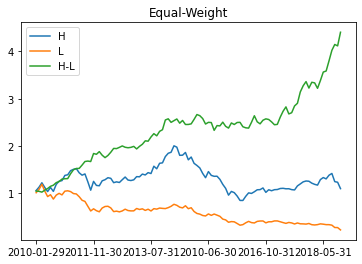

In [ ]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = (1 + r_h_ew).cumprod()
cumret['L'] = (1 + r_l_ew).cumprod()
cumret['H-L'] = (1 + r_hl_ew).cumprod()

cumret.plot(title='Equal-Weight')

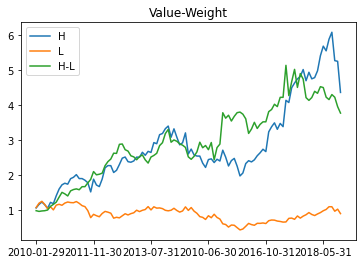

In [ ]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = (1 + r_h_vw).cumprod()
cumret['L'] = (1 + r_l_vw).cumprod()
cumret['H-L'] = (1 + r_hl_vw).cumprod()

cumret.plot(title='Value-Weight')